## EDA of House Price Prediction data
- [Document contains the complete flow](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

#### PATHS, DEPENDENCIED and CUSTOM CLASSES

In [82]:
# Paths
PWD = "/home/hanchau/proj/ds/spinny/"
TRAIN_DATA = "data/house_train.csv"
TEST_DATA = "data/house_test.csv"
CONFIG = "config.yml"
import os; os.chdir(PWD)

# Dependencies
import yaml
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from copy import copy
%matplotlib inline

plt.style.use('bmh')

# Helpers & Utils
class PreProcess:
    """
        PreProcess: Library for pre processing
    """

    def load_data(path):
        """
        Loading data
        """
        ret = pd.read_csv(path)
        print(f"Loaded file: {path}")
        return ret


    def drop_un(df, cols):
        """
        Dropping unnecessary features
        """
        try: 
            ret = df.drop(cols, axis=1)
            print(f"Dropped Columns: {cols}")
            return ret
        except: 
            ret = df.drop(cols[-1], axis=1)
            print(f"Dropped Columns: {cols[-1]}")
            return ret
    
    def drop_missing(df, thresh=0.8, cols=''):
        """
        Dropping features with more than threshold Missing Values
        """
        skipped_cols = []
        dropped_cols = []
        if not cols: cols = df.columns
        thresh = df.shape[0] * thresh

        for col in cols:
            try:
                agg = df[col].value_counts().to_frame(name='counts').T
                try: cross_thresh = (agg['NAN_CLASS'] > thresh).any()
                except: continue
                if cross_thresh:
                    df.drop(col , inplace=True, axis=1)
                    dropped_cols.append(col)
            except Exception as e:
                print(e) 
                skipped_cols.append(col)

        print(f"Dropped columns: {dropped_cols}, Couldn't Drop Columns: {skipped_cols}")
        return dropped_cols

    def check_nan(df, col):
        """
        Check nan values for each class of a feature
        """
        ret = df[col].isnull().values.sum()
        print(f"Checking nan in: {col}")
        return ret


    def count_nan(df, cols):
        """
        Check nan values for a feature
        """
        ret = df[cols].isna().sum().to_frame(name='counts')

        print(f"Counted the nan values in: {cols}")
        return ret


    def count_unique(df, cols = []):
        """
        Counts the classes for each feature
        """
        if len(cols) == 0: 
            ret = df[df.columns].nunique().to_frame(name='counts')
        else:
            ret = df.nunique().to_frame(name='counts')

        print(f"Counted the Unique Classes in: {cols}")
        return ret


    def group_feat_on_classes(df, col='counts', thres = 25):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the feature-count dataframe as input
        
        Parameters
        ----------
            thres: features with distinch values < thres will be treated as categorical
            col: count column in dataframe
        """
        feat_categ = list(df[df[col] <= thres].T.columns)
        feat_cont = list(set(df.T.columns) - set(feat_categ))
        return feat_categ, feat_cont

    
    def group_feat_on_types(df):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the dataframe as input
        """
        feat_categ = list(df.select_dtypes(include=['int64']).columns)
        feat_cont = list(set(df.columns) - set(feat_categ))
        return feat_categ, feat_cont


    def group_feat_on_manual(df, config_path):
        """
        Returns: the Categorical and Continueous features in 2 groups
        Input: Takes the external configuration as input
        """
        with open(CONFIG, "r") as config:
            config = yaml.load(config, Loader=yaml.FullLoader)
        feat_cont = config.get("continueous_feat")
        feat_categ = list(set(df.columns) - set(feat_cont))
        return feat_categ, feat_cont

  
    def make_cat(df, col, bins, labels):
        """
        Make custom groups/classes
        """
        df[col] = pd.cut(df[col], bins=bins, labels=labels)
        print(f"Made custom classes: {labels}")


    def check_agg(df, col):
        """
        Check class level aggregates for a column
        """
        ret = pd.DataFrame(df[col].value_counts())
        print(f"Checking counts in: {col}")
        return ret


    def check_agg_all(df, cols = ''):
        """
        Check class level aggregates for all columns
        """
        ret = []
        if not cols: cols = df.columns
        for col in cols:
            ret.append(pd.DataFrame(df[col].value_counts()))
        print(f"Checking class aggregates of all Columns:", end="\n")
        return ret

# {'Alley', 'Fence', 'MiscFeature', 'PoolQC'}


    def fill_na(df, cols, kind='mode'):
        """
        Various strategies for filling nan
        
        Parameters
        ----------
            type: mean, median, mode, nan_class
        """

        def fill_mode():
            """
            Modes can be multiple, pick the first one
            """
            for col in cols:
                df[col].fillna(df[col].mode()[0], inplace=True)

        def fill_median():
            for col in cols:
                df[col].fillna(df[col].median(), inplace=True)

        def fill_mean():
            for col in cols:
                df[col].fillna(df[col].mean(), inplace=True)

        def fill_nan_class():
            for col in cols:
                df[col].fillna("NAN_CLASS", inplace=True)

        if kind=='mode':
            fill_mode()
        elif kind=='mean':
            fill_mean()
        elif kind=='median':
            fill_median()
        elif kind=='nan_class':
            fill_nan_class()

        print(f"Fill NAN strategy: {kind}")


    def info(df):
        """
        Get the basic info of data frame
        """
        shape = df.shape
        print(f"All features and Null Counts:", end="\n") 
        return df.info()
        print("\n\n\n")
    

    def get_nan(df):
        """
        Get the columns with nan to handle
        """
        ret = df.columns[df.isna().any()].tolist()
        print(f"#NAN columns: {len(ret)}, NAN columns: {ret}", end="\n\n") 
        return ret


    def describe(df):
        """
        Comprehensive aggregates description of all features
        """
        print(f"Comprehensive aggregate description", end="\n")
        return df.describe(include='all').T


    def describe_missing(df):
        """
        Comprehensive aggregates description of the features with nan values
        """
        print(f"Aggregate description for Missing", end="\n")
        ret = df.describe(include='all').T
        ret = ret[ret['count'] != df.shape[0]]
        print(ret)
        return ret

class EDA:
    """
    EDA: Library for ploting and analysing after Pre Processing
    """

    def describe(df, cols = ''):
        """
        Comprehensive aggregates description of all features
        """
        print(f"Comprehensive aggregate description", end="\n")
        if not cols:
            ret = df.describe(include='all').T
        ret = df[cols].describe(include='all').T
        return ret



    def set_palette():
        """
        Set the colors that will be used in the EDA plots
        """
        custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]
        customPalette = sns.set_palette(sns.color_palette(custom_colors))
        sns.palplot(sns.color_palette(custom_colors),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return custom_colors


    def get_palette(colors, color):
        """
        Get a gradient type color palette
        """
        palette = sns.dark_palette(colors[color], reverse=True)
        sns.palplot(sns.color_palette(palette),size=1)
        plt.tick_params(axis='both', labelsize=0, length = 0)
        return palette


    def plot_grad(df, col):
        """
        Simple plot of x vs y
        """ 
        print(f"Gradient plot of: {col}")
        ret = df.sort_values(by=col, ascending=False).style.background_gradient(cmap='Reds')
        return ret


    def plot_dist(df, col):
        """
        Simple plot of distribution of samples across col values
        """
        print(f"Ploting columns: {col}", end="\n")
        sns.displot(df[col])


    def plot_box(df, cols):
        """
        Simple box plot
        """
        print(f"Ploting box: {cols}", end="\n")
        plt.figure(figsize=(15,5))
        i = 1
        for col in cols:
            plt.subplot(1,3,i)
            a1 = sns.boxplot(data=df,y=col)
            i+=1
 

    def plot_dist_all(df, cols = [], kind = 'box', target = '', sections = '', width = 100):
        """
        Simple plots of distribution of samples across all columns

        Parameters
        ----------
            df:  data
            cols:  cols to consider
            kind:  which kind of plot
            target:  values on y axes
            sections:  no. of columns of subplots
        TODO:
            Add feature of axis - ax=axes[i//sections, i%sections], 
        """
        print(f"Plotting all features distribution.\nIt may take a while..", end="\n\n")
        skipped_cols = []
        if cols is None: cols = df.columns 
        
        if not sections: 
            pass
        else: 
            fig, axes = plt.subplots(len(cols)//sections + 1, sections, figsize=(30, width))
        
        for i, col in enumerate(cols):
            try: 
                if kind == 'box':
                    sns.boxplot(data=df, x=col, y=target, ax=axes[i//sections, i%sections])
                elif kind == 'hist':
                    sns.displot(data=df, x=col, kind='hist')
                elif kind == 'kde':
                    sns.displot(data=df, x=col, kind='kde')
                elif kind == 'ecdf':
                    sns.displot(data=df, x=col, kind='ecdf', ax=axes[i//sections, i%sections])
                elif kind == 'bar':
                    sns.barplot(ax=axes[i//sections, i%sections], data=df, x=col, y=target)
            except Exception as e: 
                print(e)
                skipped_cols.append(col)
        return skipped_cols


    def plot_hist_all(df, cols = [], bins=50, size = (10, 10)):
        temp = df[cols]
        temp.hist(figsize=size, bins=bins, xlabelsize=8, ylabelsize=8)


    def pair_wise_corr(df, cols = [], size = (10,10), sections=2, target='SalePrice'):
        rows = len(cols)//sections
        secs = len(cols)%sections

        fig, axs = plt.subplots(rows, secs, figsize=(secs*3.5,rows*3))

        for r in range(0,rows):
            for c in range(0,secs):  
                i = r*secs+c
                if i < len(cols):
                    sns.regplot(df[cols[i]], df[target], ax = axs[r][c])
                    stp = stats.pearsonr(df[cols[i]], df[target])
                    str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
                    axs[r][c].set_title(str_title,fontsize=11)
        plt.tight_layout()    
        plt.show()   


    def plot_cont(df, col):
        """
        Plot contingency matrix for a column
        """
        pass


    def plot_cont_all(df, cols = []):
        """
        Plot contingency matrix for all columns
        """
        pass



# Data loading
data = PreProcess.load_data(TRAIN_DATA)
t_data = PreProcess.load_data(TEST_DATA)

Loaded file: data/house_train.csv
Loaded file: data/house_test.csv


#### STUDY AND CLEAN FEATURES

    1. There are 81 Features with 18 features having Missing Values
    2. The #samples we have here are - 1168

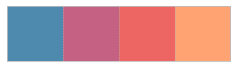

In [3]:
# Set the working palette
colors = EDA.set_palette()

In [4]:
# PreProcess.info(data)
desc = PreProcess.describe(data)
desc

Comprehensive aggregate description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1168.0,NaN,NaN,NaN,583.5,337.316864,0.0,291.75,583.5,875.25,1167.0
MSSubClass,1168.0,NaN,NaN,NaN,57.251712,42.189213,20.0,20.0,50.0,70.0,190.0
MSZoning,1168,5,RL,912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,982.0,NaN,NaN,NaN,70.092668,24.737533,21.0,59.0,69.0,80.0,313.0
LotArea,1168.0,NaN,NaN,NaN,10571.564212,10543.102521,1300.0,7487.25,9355.0,11530.0,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1168.0,NaN,NaN,NaN,6.357877,2.679448,1.0,5.0,6.0,8.0,12.0
YrSold,1168.0,NaN,NaN,NaN,2007.797945,1.328069,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1168,9,WD,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1168,6,Normal,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN



      1. There are two types of features --> Categorical and Continueous
      2. All the features are mentioned  

[here](https://docs.google.com/document/d/14CjFWvGZS9hyNudNY46WK1OasQNBuOrobnsO2wGEXR8/edit?usp=sharing)

In [5]:
# Categorical or Continueous
agg = PreProcess.check_agg_all(data)
print(agg[0])

Checking class aggregates of all Columns:
      Id
0      1
767    1
783    1
782    1
781    1
...   ..
388    1
387    1
386    1
385    1
1167   1

[1168 rows x 1 columns]


In [6]:
# Missing Values
nan_cols = PreProcess.get_nan(data)
missing = PreProcess.count_nan(data, nan_cols)
EDA.plot_grad(missing, col='counts')

#NAN columns: 18, NAN columns: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

Counted the nan values in: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Gradient plot of: counts


,counts
PoolQC,1165
MiscFeature,1128
Alley,1094
Fence,946
FireplaceQu,554
LotFrontage,186
GarageType,65
GarageYrBlt,65
GarageFinish,65
GarageQual,65


Comprehensive aggregate description
Aggregate description for Missing
               count unique     top  freq        mean         std     min  \
LotFrontage    982.0    NaN     NaN   NaN   70.092668   24.737533    21.0   
Alley             74      2    Grvl    39         NaN         NaN     NaN   
MasVnrType      1161      4    None   696         NaN         NaN     NaN   
MasVnrArea    1161.0    NaN     NaN   NaN  104.009475  181.134311     0.0   
BsmtQual        1135      4      TA   525         NaN         NaN     NaN   
BsmtCond        1135      4      TA  1046         NaN         NaN     NaN   
BsmtExposure    1134      4      No   761         NaN         NaN     NaN   
BsmtFinType1    1135      6     Unf   339         NaN         NaN     NaN   
BsmtFinType2    1135      6     Unf  1005         NaN         NaN     NaN   
FireplaceQu      614      5      Gd   312         NaN         NaN     NaN   
GarageType      1103      6  Attchd   690         NaN         NaN     NaN   
Garage

[]

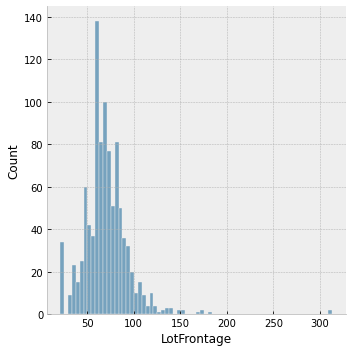

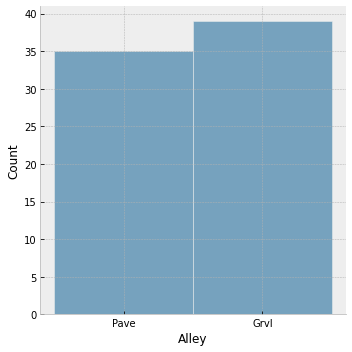

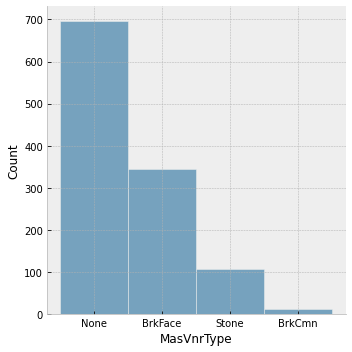

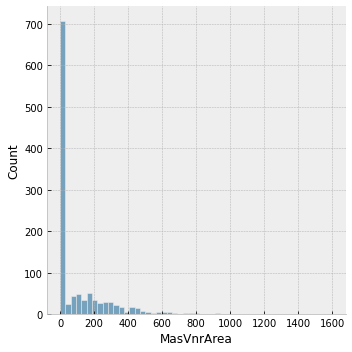

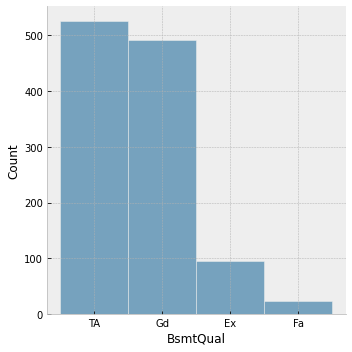

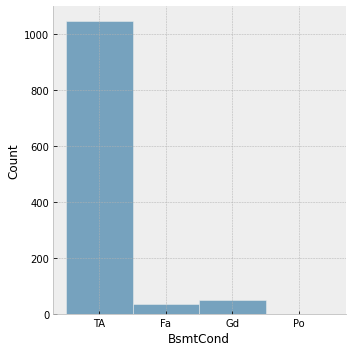

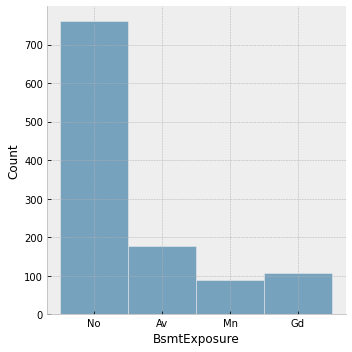

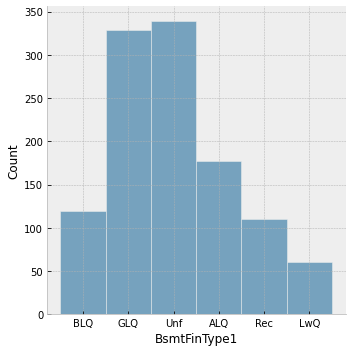

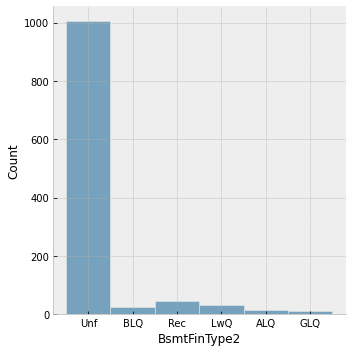

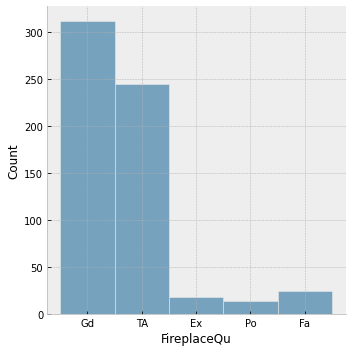

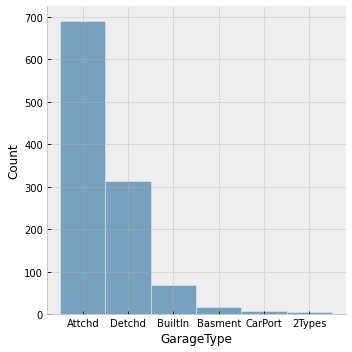

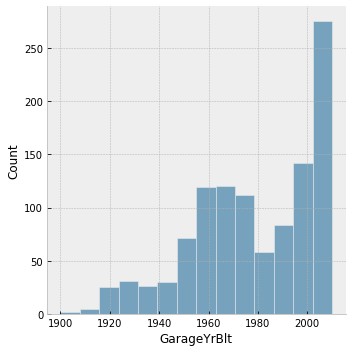

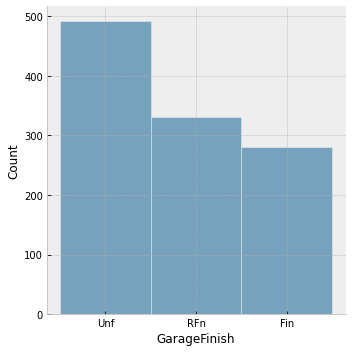

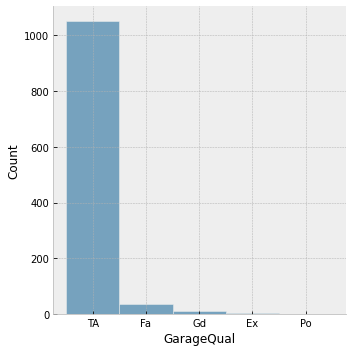

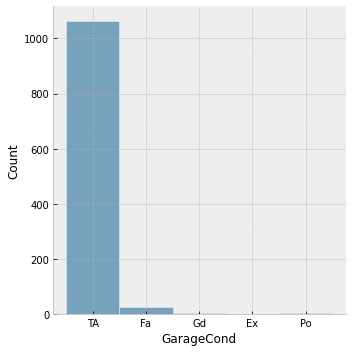

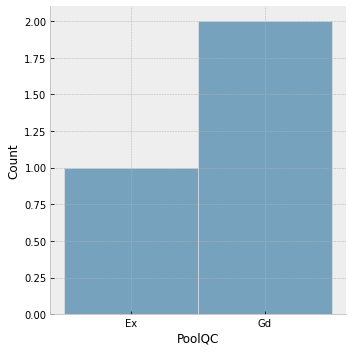

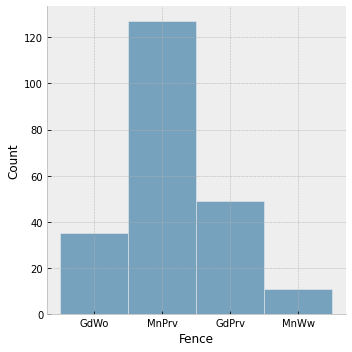

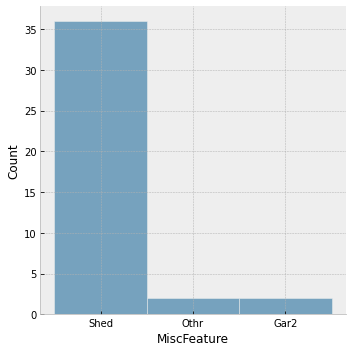

In [7]:
# Figuering out "Filling missing values" strategy

desc = PreProcess.describe(data)
desc = PreProcess.describe_missing(data)


# Distribution - hist, kde, ecdf
EDA.plot_dist_all(data, cols = desc.T.columns, kind = 'hist', target = 'SalePrice')


    Missing Vlaues
    
    These 3 feature have missing values becuase of improper data

    1. GarageYrBlt   - nan are missing values - [Mode]
    2. LotFrontage    - skewed normal distribution - [Median]
    3. MasVnrArea     - nan are missing values, 0 are more than half - [Mode]

    These 15 features have missing or nan values becuase it represents a separate class   

    1. PoolQC         - nan means the pool is absent in the property - [NAN class]
    2. Alley          - nan means no alley access - [NAN class]
    3. MasVnrType     - nan means no masonry veneeer types - [NAN class]
    4. BsmtQual       - nan means no basement - [NAN class]
    5. BsmtCond       - nan means no basement - [NAN class]
    6. BsmtExposure   - nan means no basement - [NAN class]
    7. BsmtFinType1   - nan means no basement - [NAN class]
    8. BsmtFinType2   - nan means no basement - [NAN class]
    9. FireplaceQu    - nan means no fireplace - [NAN class]
    10. GarageType    - nan means no fireplace - [NAN class]
    11. GarageFinish  - nan means no garage - [NAN class]
    12. GarageQual    - nan means no garage - [NAN class]
    13. GarageCond    - nan means no garage - [NAN class]
    14. Fence         - nan means no fence - [NAN class]
    15. MiscFeature   - nan means no misc feature - [NAN class]

    Filling Strategy 

    1. If the data is centered around mean --> Fill the mean or median
    2. If the data is categorical --> Fill mode

    Observation

    1. In LotFrontage --> Median can be used because points are mostly centered around Mean
    2. In other two cases --> Mode seems to be the best alternative

Ploting box: ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']
Comprehensive aggregate description


,count,mean,std,min,25%,50%,75%,max
GarageYrBlt,1103.0,1978.067090,24.950751,1900.0,1960.0,1979.0,2002.0,2010.0
MasVnrArea,1161.0,104.009475,181.134311,0.0,0.0,0.0,168.0,1600.0
LotFrontage,982.0,70.092668,24.737533,21.0,59.0,69.0,80.0,313.0


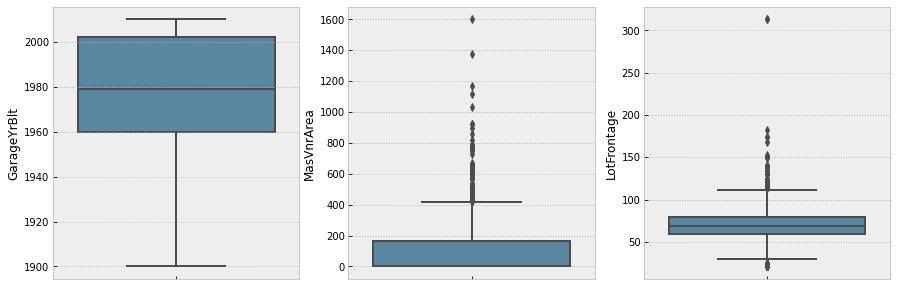

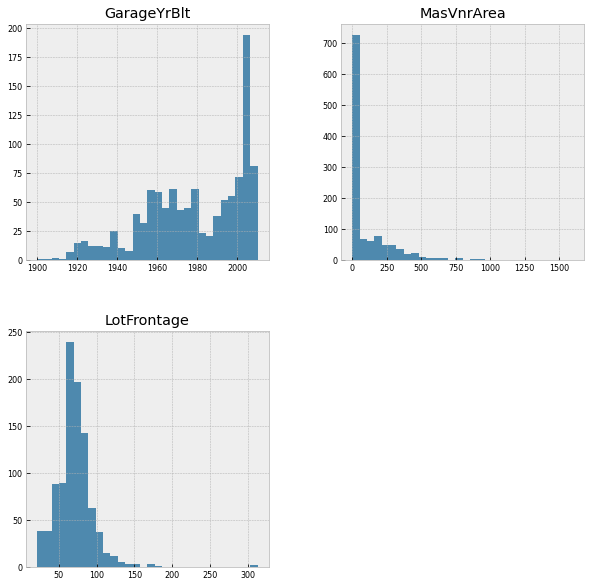

In [8]:
#### Check the distribution of Features with Missing Values

feat = ['GarageYrBlt', 'MasVnrArea', 'LotFrontage']
EDA.plot_box(data, cols=feat)
EDA.plot_hist_all(data, cols=feat, bins=30, size=(10,10))

EDA.describe(data, feat)

    Filling the missing Values

In [32]:
# Filling Missing Values

feat_mode = ['GarageYrBlt', 'MasVnrArea']
feat_median = ['LotFrontage']
feat_na_class = list(set(nan_cols) - set(feat_mode + feat_median))


# New dataframe
data_fld_na = copy(data)
PreProcess.fill_na(data_fld_na, feat_mode, kind='mode')
PreProcess.fill_na(data_fld_na, feat_median, kind='median')
PreProcess.fill_na(data_fld_na, feat_na_class, kind='nan_class')


# Plots after filling nan
EDA.plot_dist_all(data_fld_na, cols = desc.T.columns, target = 'SalePrice')


# New summary
PreProcess.describe(data_fld_na)

Fill NAN strategy: mode
Fill NAN strategy: median
Fill NAN strategy: nan_class
Plotting all features distribution.
It may take a while..

local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assignment
local variable 'axes' referenced before assign

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1168.0,NaN,NaN,NaN,583.5,337.316864,0.0,291.75,583.5,875.25,1167.0
MSSubClass,1168.0,NaN,NaN,NaN,57.251712,42.189213,20.0,20.0,50.0,70.0,190.0
MSZoning,1168,5,RL,912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1168.0,NaN,NaN,NaN,69.918664,22.684175,21.0,60.0,69.0,79.0,313.0
LotArea,1168.0,NaN,NaN,NaN,10571.564212,10543.102521,1300.0,7487.25,9355.0,11530.0,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1168.0,NaN,NaN,NaN,6.357877,2.679448,1.0,5.0,6.0,8.0,12.0
YrSold,1168.0,NaN,NaN,NaN,2007.797945,1.328069,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1168,9,WD,1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1168,6,Normal,956,NaN,NaN,NaN,NaN,NaN,NaN,NaN


    Groups of Features
    
    1. Features are grouped into 2 groups - Categorical and Continueous
    2. The plots for these features can be plotted seperately
    3. These two groups can be based on 3 Strategies
       1. IF # Unique classes in features <= 25 THEN Categorical
       2. IF Type(feature) is not integer THEN Categorical 
       3. Manually listing the categorical features

In [34]:
# Categorical or Continueous
feature_classes = PreProcess.count_unique(data_fld_na)
plot_feat_classes = EDA.plot_grad(feature_classes, col='counts')

# Grouping similar features --> # Based on IF Unique vlues of Features <= 25 then Categorical
feat_categ1, feat_cont1 = PreProcess.group_feat_on_classes(feature_classes, thres=25)


# Grouping similar features --> # Based on If types(feat) == 'int64' then Categorical
feat_categ2, feat_cont2 = PreProcess.group_feat_on_types(data_fld_na)


# Grouping similar features --> # Groups made manually
feat_categ3, feat_cont3 = PreProcess.group_feat_on_manual(data_fld_na, CONFIG)


Counted the Unique Classes in: []
Gradient plot of: counts


In [35]:
# Finall Check: Ensure data is clean
PreProcess.check_agg_all(data_fld_na, cols = feat_categ2)

Checking class aggregates of all Columns:


[      Id
 0      1
 767    1
 783    1
 782    1
 781    1
 ...   ..
 388    1
 387    1
 386    1
 385    1
 1167   1
 
 [1168 rows x 1 columns],
      MSSubClass
 20          422
 60          234
 50          116
 120          74
 30           57
 160          54
 70           48
 90           45
 80           43
 190          23
 85           18
 75           14
 45           12
 180           5
 40            3,
        LotArea
 9600        22
 7200        21
 6000        16
 10800       12
 8400        10
 ...        ...
 7259         1
 10659        1
 7100         1
 6970         1
 17104        1
 
 [883 rows x 1 columns],
     OverallQual
 5           316
 6           296
 7           273
 8           126
 4            93
 9            33
 10           14
 3            14
 2             3,
    OverallCond
 5          643
 6          201
 7          175
 8           65
 4           40
 3           22
 9           19
 2            3,
       YearBuilt
 2006         56
 2005     

### FEATURES IMPORTANCE

    TARGET

    1. Distribution of target across samples
    2. Info of target 

Ploting columns: SalePrice


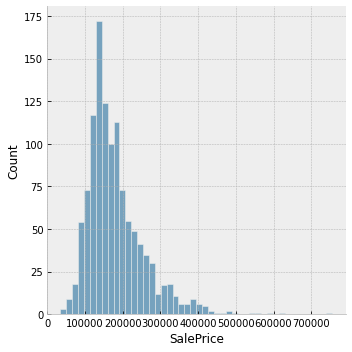

In [12]:
# Check distribution of target
EDA.plot_dist(data, "SalePrice")

    CATEGORICAL FEATURES

    1. Feature vs target plots
    2. Observatinos, correlations and Insights
    3. Drop the unnecessary features

Plotting all features distribution.
It may take a while..



[]

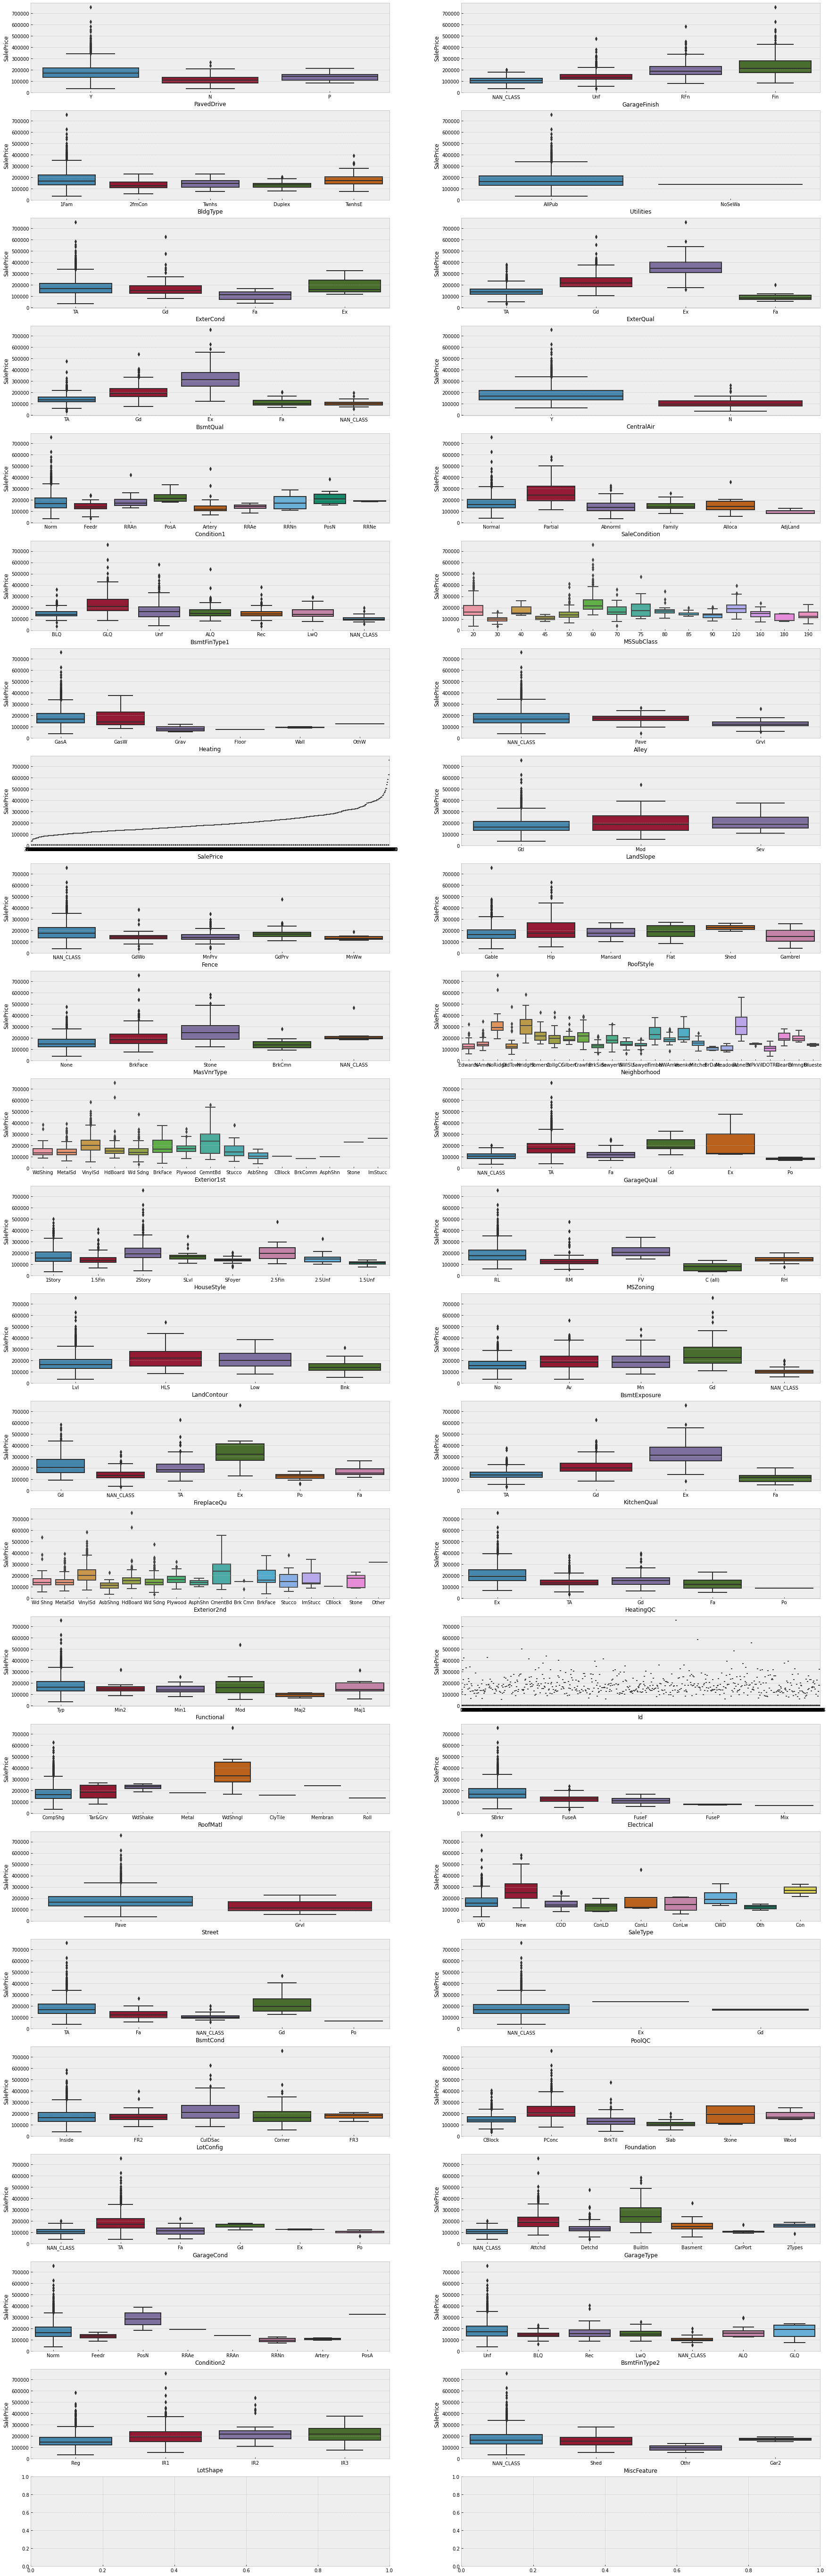

In [74]:
# Check distribution of categorical features
EDA.plot_dist_all(data_fld_na, cols=feat_categ3, kind='box', sections=2, target='SalePrice')

    Few Observations from feature-target plots [Categorical]
    
    Correlations:

    1. HeatingQC: Better the quality, higher the SalePrice
    2. BsmtExposure: As the quality increases, prices increases
    3. GarageCond: Counter Intuitively Typical Garage condition houses have 
        high SalePrice
    4. KitcheQuality: Betterr the quality, higher the SalePrice
    5. LotShape: More irregular the shape, higher the SalePrice
    6. GarageQual: Counter Intuitively Typical Garage Quality houses have 
        high + variance in SalePrice. Even mean SalePrice of Typical Garage quality houses is higher than Excellent Garage Quality houses
    7. Electrical: Better the Electrical System, higher is the SalePrice
    8. BsmtQual: Better the quality, higher the SalePrice
    9. PoolQC: Better the quality, higher the SalePrice 
    10. GarageFinish: More finished the garage, higher the SalePrice
    11. BsmtCond: Better the condition, higher the SalePrice

    Other Insights:

    1. Heating: GasA category has exceptionally high SalePrice
    2. SaleCondition: Partially complete houses have high SalePrice
    3.  Exterior2nd: CmentBd has high Mean SalePrice (on average)
    4.  PavedDrive: Houses with paved drive has high SalePrice
    5.  MSZoning: Floating Villace residential have high mean SalePrice, but 
        Medium and Low density regions have high + variance
    6.  RoofMatl: Wood Shingles have high SalePrices, Standad Shingle have   
        high variance
    7.  SaleType: New houses have high SalePrice
    8.  CentralAir: Houses with central air have high SalePrice
    9.  Foundation: Stone, PConc, CBlock, Wood foundation houses have high 
        SalePrice
    10. Condition2: Houses near the Positive Off-site fetches high SalePrice
    11. Street: Paved streets houses have high SalePrice
    12. LandContour: Houses with Banked contour have LOW SalePrice
    13. Alley: Grvl alley have low SalePrice
    14. Functional: Major deduction 2 houses have low SalePrice
    15. HouseStyle: Unfinished storied houses have less SalePrice than Finished Storied houses

    Dropping features
    
    1. Categorical - with high missing values : >80% NAN

In [73]:
# Features with very less data
PreProcess.check_agg_all(data_fld_na, cols = feat_categ3)
data_drop = copy(data_fld_na)
PreProcess.drop_missing(data_drop, cols=feat_categ3, thresh = 0.8)
data_drop.shape

Checking class aggregates of all Columns:
Dropped columns: ['Alley', 'Fence', 'PoolQC', 'MiscFeature'], Couldn't Drop Columns: []


(1168, 77)

    CONTINUEOUS FEATURES

    1. Distribution of continueous features
    2. Pair-wise correlations
    3. Feature v Target plots
    4. Feature - Target correlations

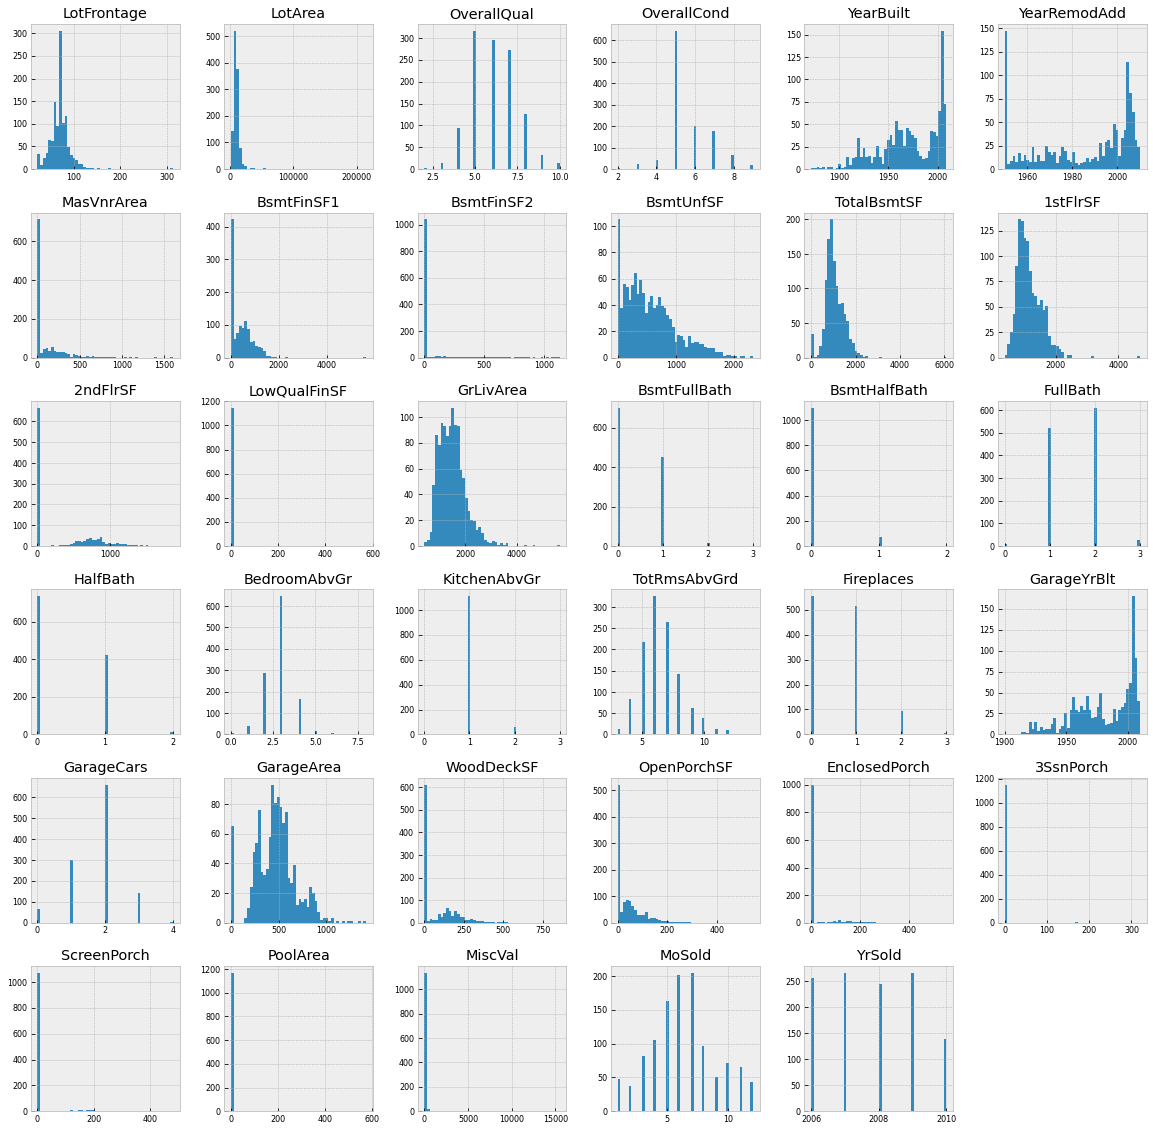

In [75]:
# Check distribution of Continueous features
EDA.plot_hist_all(data_drop, cols=feat_cont3, size=(20,20))

TypeError: 'AxesSubplot' object is not subscriptable

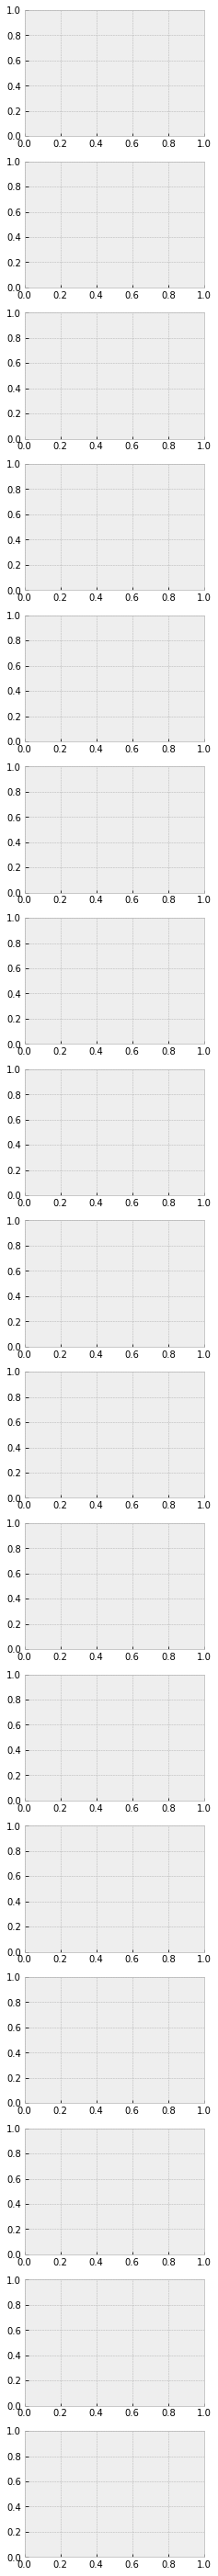

In [83]:
# Check pair-wise similarity among features
EDA.pair_wise_corr(data_drop, cols=feat_cont3, size=(20,20))

#### ROUGH WORK

In [67]:
df = copy(data_fld_na)
thresh = 0.8 * df.shape[0]
cols = feat_categ3
skipped_cols = []
if not cols: cols = df.columns


# for col in cols:
#     try:
#         agg = df[col].value_counts().to_frame('counts').T
#         print(agg)
#         print(col)
#         cross_thresh = (agg['NAN_CLASS'] > thresh).any()
#         if cross_thresh:
#             df.drop(col , inplace=True, axis=1)
#     except Exception as er:
#         print(er)
#         skipped_cols.append(col)
#     break

# print(f"Couldn't Drop Columns: {skipped_cols}")
# agg = df[col].value_counts().to_frame('counts').T

# agg = df['Paved'].value_counts().to_frame('counts').T
agg = df['PavedDrive'].value_counts().to_frame(name='counts').T



### ARCHIVES

In [65]:
# Before Cleaning Plots
# EDA.plot_all_dist(data)

# def plot_all_bar(df, target=""):
#     print(f"Plotting all features.\nIt may take a while..", end="\n\n")
#     plt.figure(figsize=(20, 10))
#     plot_id = 321
#     skipped_cols = []
#     def _plot_one(df, col):
#         try:
#             plt.subplot(plot_id)
#             sns.barplot(x = col, y = target, data = df)
#         except: skipped_cols.append(col)

#     for col in df.columns:
#         _plot_one(df, col)
#         plot_id += 1
    
#     print(f"Few columns faced exception: {skipped_cols}")